In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading data (Breast Cancer Wisconsin)

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases'
    '/breast-cancer-wisconsin/wdbc.data',
    header=None)

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

# Streamline with pipeline

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])
print("The pipeline steps: ", pipeline.steps)
pipeline


The pipeline steps:  [('scaler', StandardScaler()), ('classifier', LogisticRegression())]


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

In [4]:
# Get the classifier from the pipeline
classifier = pipeline.named_steps['classifier']
classifier

LogisticRegression()

In [5]:
# Get the scaler from the pipeline
scaler = pipeline.named_steps['scaler']
scaler

StandardScaler()

In [6]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
print("The pipeline steps: ", pipeline.steps)
pipeline

The pipeline steps:  [('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression())]


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [7]:
# Get the classifier from the pipeline
classifier = pipeline.named_steps['logisticregression']
classifier

LogisticRegression()

In [8]:
# Get the scaler from the pipeline
scaler = pipeline.named_steps['standardscaler']
scaler

StandardScaler()

# K-fold cross-validation

In [21]:
# Create model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1,
                                           solver='lbfgs'))


In [22]:
# Stratified cross-validation
from sklearn.model_selection import StratifiedKFold

# Generate n folds and its index of train and test each fold.
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f"Fold: {k}, Class dist.: {np.bincount(y_train[train])}, Acc: {score}")

print(f"CV Accuracy: {round(np.mean(scores), 3)} +/- {round(np.std(scores), 3)}")


Fold: 0, Class dist.: [256 153], Acc: 0.9347826086956522
Fold: 1, Class dist.: [256 153], Acc: 0.9347826086956522
Fold: 2, Class dist.: [256 153], Acc: 0.9565217391304348
Fold: 3, Class dist.: [256 153], Acc: 0.9565217391304348
Fold: 4, Class dist.: [256 153], Acc: 0.9347826086956522
Fold: 5, Class dist.: [257 153], Acc: 0.9555555555555556
Fold: 6, Class dist.: [257 153], Acc: 0.9777777777777777
Fold: 7, Class dist.: [257 153], Acc: 0.9333333333333333
Fold: 8, Class dist.: [257 153], Acc: 0.9555555555555556
Fold: 9, Class dist.: [257 153], Acc: 0.9555555555555556
CV Accuracy: 0.95 +/- 0.014


In [24]:
# Shortcut function

from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f"CV Accuracy: {round(np.mean(scores), 3)} +/- {round(np.std(scores), 3)}")


CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV Accuracy: 0.95 +/- 0.014


# Tuning hyperparameters via Grid Search Cross Validation

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [26]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
# NOTE:
# Please note that fitting a model with the best settings
#   (gs.best_estimator_) on the training set manually via
#   clf.fit(X_train, y_train) after completing the
#   grid search is not necessary if we set refit=True.

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


# Tuning Hyperparameter via Grid Search Nested Cross Validation

In [29]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

# Define the number of outer folds for NCV
outer_k = 5
# Initialize the outer KFold cross-validator
outer_kf = KFold(n_splits=outer_k, shuffle=True, random_state=42)

# Define the parameter grid to search
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

# Initialize the random forest classifier
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

# Initialize variables to store performance metrics and models
best_model = None
best_params = None
best_accuracy = 0

# Iterate over each outer fold
for train_index, test_index in outer_kf.split(X):
    # Split the data into training and testing sets for this outer fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize the inner KFold cross-validator for hyperparameter tuning
    inner_kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Initialize the GridSearchCV with the random forest classifier, parameter grid, and inner KFold CV
    grid_search = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, cv=inner_kf, scoring='accuracy')
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters and the corresponding mean cross-validated score
    curr_best_params = grid_search.best_params_
    
    # Use the best hyperparameters to train a model on the entire training set from this outer fold
    curr_best_model = grid_search.best_estimator_
    curr_best_model.fit(X_train, y_train)
    
    # Evaluate the trained model on the held-out test set from this outer fold
    y_pred = curr_best_model.predict(X_test)
    curr_accuracy = np.mean(y_pred == y_test)
    
    # Store the model and hyperparameters if it achieves the best accuracy
    if curr_accuracy > best_accuracy:
        best_model = curr_best_model
        best_params = curr_best_params
        best_accuracy = curr_accuracy

# Train the final best model on the entire dataset (all data points) using the selected best hyperparameters
final_best_model = best_model
final_best_model.fit(X, y)

print("Best hyperparameters:", best_params)
print("Best accuracy across all outer folds:", best_accuracy)
print("Final best model trained on entire dataset:", final_best_model)


Best hyperparameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best accuracy across all outer folds: 0.9824561403508771
Final best model trained on entire dataset: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.1, kernel='linear', random_state=1))])


# Diagnosing bias and variance problems with learning curves

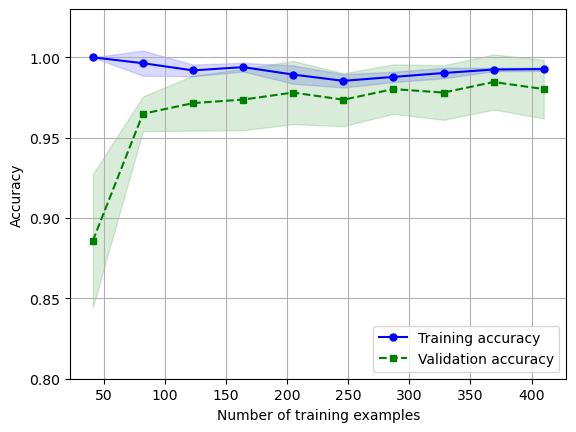

In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Create a pipeline with StandardScaler and LogisticRegression
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', max_iter=10000)
)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1
)

# Calculate means and standard deviations of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.grid()
plt.show()


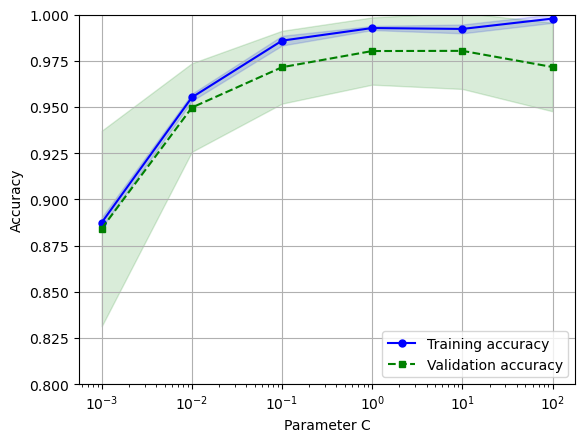

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()
